In [245]:
%matplotlib inline
import matplotlib.pyplot as plt
from prettytable import PrettyTable

from collections import defaultdict
import copy
from omegaconf import OmegaConf 
from datetime import datetime

import scipy.stats as stats
import numpy as np
import jsonlines
from pathlib import Path
from hydra import initialize, compose
import torchvision

import dr_util.file_utils as fu
import dr_gen.utils.model as mu
import dr_gen.utils.run as ru

import dr_gen.utils.result_parsing as rp
import dr_gen.utils.result_plotting as rplt
import dr_gen.utils.plot_utils as pu

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setup Config and Generator

In [8]:
with initialize(config_path="../configs/", version_base=None):
    cfg = compose(
        config_name="config.yaml",
        overrides=[
            "paths=mac",
        ]
    )

In [4]:
generator = ru.set_deterministic(cfg.seed)

In [9]:
print(OmegaConf.to_yaml(OmegaConf.to_container(cfg.paths, resolve=True)))

root: /Users/daniellerothermel/drotherm
proj_dir_name: dr_gen
data: /Users/daniellerothermel/drotherm/data
logs: /Users/daniellerothermel/drotherm/logs
my_data: /Users/daniellerothermel/drotherm/data/dr_gen
my_logs: /Users/daniellerothermel/drotherm/logs/dr_gen
run_dir: /Users/daniellerothermel/drotherm/logs/dr_gen/bs500/lr0.1/wd0.0001/s0/2025-03-03/15-56-1741039002
dataset_cache_root: /Users/daniellerothermel/drotherm/data/cifar10/
agg_results: /Users/daniellerothermel/drotherm/data/dr_gen/cifar10/cluster_runs/lr_wd_init_v0



### Util Usage

#### Loading and Parsing Run Logs

In [39]:
# Example: Loading all Runs from Root Dir
run_logs = rp.get_all_logs(cfg.paths.agg_results)
print(f"\nFirst Run Keys: {run_logs[0].keys()}")

>> Getting logs from all runs in:
    /Users/daniellerothermel/drotherm/data/dr_gen/cifar10/cluster_runs/lr_wd_init_v0
>> Found 1,288 files
>> Loading files

First Run Keys: dict_keys(['log_path', 'log_data'])


In [45]:
# Example: Parsing a Single Run Log
rcfg, rmets, rmd = rp.parse_run_log(
    run_logs[0]['log_path'],
    run_logs[0]['log_data'],
)
print(f"\nSplits in first run: {list(rmets.keys())}")
print(f"\nFirst epoch train metrics:")
for k, v in rmets['train'][0].items():
    print(f"  - {k}: {v}")


Splits in first run: ['train', 'val', 'eval']

First epoch train metrics:
  - epoch: 0
  - loss: 1.841132915019989
  - acc1: 33.11750059127807
  - acc5: 84.29500131607055


In [48]:
# Example: Parsing all runs, dropping error runs
print(f">> Parsing {len(run_logs):,} Runs")
good_runs, bad_runs = rp.parse_run_logs(run_logs)
print(f"   - num good: {len(good_runs):,}")
print(f"   - num w/ errors: {len(bad_runs):,}")

>> Parsing 1,288 Runs
   - num good: 1,288
   - num w/ errors: 0


#### Determining the Sweeps in the Data

In [90]:
!uv add prettytable

Resolved 141 packages in 3.13s                                       
Prepared 2 packages in 568ms                                             
Uninstalled 1 package in 0.84ms
Installed 2 packages in 1msfile:///Users/daniellerothermel/d
 ~ dr-gen==0.1.0 (from file:///Users/daniellerothermel/drotherm/repos/dr_gen)
 + prettytable==3.15.1


In [129]:
def make_table(fns, rows):
    table = PrettyTable()
    table.field_names = fns
    if isinstance(rows[0][0], list):
        for rrs in rows:
            table.add_rows(rrs, divider=True)
    else:
        table.add_rows(rows)
    return table

In [143]:
# Example: Getting Sweep Info & Simple Display
sweep_info = rp.extract_sweeps(good_runs)
swept_table = make_table(*rp.get_swept_table(sweep_info['swept_vals']))
print(f"Swept Values:\n{swept_table}")

Swept Values:
+--------------------+---------+-------+
|        Key         |  Values | Count |
+--------------------+---------+-------+
|   model.weights    |   None  |  680  |
|                    | DEFAULT |  608  |
+--------------------+---------+-------+
| optim.weight_decay | 0.00025 |  200  |
|                    | 0.00016 |  200  |
|                    | 6.3e-05 |  200  |
|                    |  0.0001 |  423  |
|                    |  4e-05  |  200  |
|                    |  1e-05  |   65  |
+--------------------+---------+-------+
|      optim.lr      |   0.04  |  200  |
|                    |   0.06  |  200  |
|                    |   0.25  |  200  |
|                    |   0.1   |  383  |
|                    |   0.16  |  200  |
|                    |   0.2   |   40  |
|                    |   0.01  |   65  |
+--------------------+---------+-------+
|  optim.step_size   |    90   |  1287 |
|                    |    60   |   1   |
+--------------------+---------+-------+
| 

In [144]:
# Example: Show the Sweep Combo Run Info
combo_table = make_table(*rp.get_combo_table_contents(
    sweep_info['combo_key_order'],
    sweep_info['combo_inds'],
))

print(">> First 5 lines of combos")
print(combo_table.get_string(start=0, end=5))

print("\n>> Just Default HPMs")
def filter_function(vals):
    return (
        #vals[0] == "None" and   # Init
        vals[1] == "0.1" and     # LR
        vals[2] == "0.0001" and  # WD
        vals[4] == "270"         # Epochs
    )
print(combo_table.get_string(row_filter=filter_function))

>> First 5 lines of combos
+------+------+---------+-----------------+--------+-------+
| Init |  LR  |    WD   | optim.step_size | epochs | Count |
+------+------+---------+-----------------+--------+-------+
| None | 0.25 | 6.3e-05 |        90       |  270   |   20  |
| None | 0.25 |  4e-05  |        90       |  270   |   20  |
| None | 0.25 | 0.00025 |        90       |  270   |   20  |
| None | 0.25 | 0.00016 |        90       |  270   |   20  |
| None | 0.25 |  0.0001 |        90       |  270   |   20  |
+------+------+---------+-----------------+--------+-------+

>> Just Default HPMs
+---------+-----+--------+-----------------+--------+-------+
|   Init  |  LR |   WD   | optim.step_size | epochs | Count |
+---------+-----+--------+-----------------+--------+-------+
|   None  | 0.1 | 0.0001 |        90       |  270   |   99  |
| DEFAULT | 0.1 | 0.0001 |        90       |  270   |  103  |
+---------+-----+--------+-----------------+--------+-------+


In [142]:
# Example: Get inds for specific configuration
# Here selected_inds is {(combo_keys): [inds, ...]}
selected_inds = rp.get_inds_by_kvs(
    sweep_info['combo_key_order'], sweep_info['combo_inds'],
    {
        'epochs': '270',
        'model.weights': 'None',
        'optim.lr': '0.1',
    },
)
make_table(
    [*sweep_info['combo_key_order'], "Count"],
    [[*k, len(selected_inds[k])] for k in selected_inds.keys()],
)

model.weights,optim.weight_decay,optim.lr,optim.step_size,epochs,Count
None,0.00025,0.1,90,270,20
None,0.0001,0.1,90,270,99
None,4e-05,0.1,90,270,20
None,6.3e-05,0.1,90,270,20
None,0.00016,0.1,90,270,20
None,1e-05,0.1,90,270,20


#### Format and Extract Metrics

In [150]:
all_runs_metrics = rp.remap_run_list_metrics(good_runs)
print(f">> Splits: {list(all_runs_metrics.keys())}")
print(f">> Metrics: {list(all_runs_metrics['train'].keys())}")

>> Splits: ['train', 'val', 'eval']
>> Metrics: ['epoch', 'loss', 'acc1', 'acc5']


In [171]:
# Example: Get specific metric for a single run
rp.get_run_metrics(all_runs_metrics, "train", "loss", 0)[:5]

[1.841132915019989,
 1.4623212695121766,
 1.3068945199251174,
 1.198164589703083,
 1.113237025588751]

In [168]:
# Example: Get specific metric for list of inds
two_mets = rp.get_runs_metrics(all_runs_metrics, "train", "loss", [0,1])
print(">> Loss for two runs")
make_table(['Run 0', 'Run 1'], [[two_mets[0][i], two_mets[1][i]] for i in range(4)])

>> Loss for two runs


Run 0,Run 1
1.841132915019989,1.8647861450910568
1.4623212695121766,1.4779982462525367
1.3068945199251174,1.3190233439207077
1.198164589703083,1.2109674647450448


In [189]:
# Example: Get inds for specific configuration
# Here selected_inds is {(combo_keys): [inds, ...]}
selected_inds = rp.get_inds_by_kvs(
    sweep_info['combo_key_order'], sweep_info['combo_inds'],
    {
        'epochs': '270',
        #'model.weights': 'None',
        'optim.lr': '0.1',
        'optim.weight_decay': '0.0001',
    },
)
print(make_table(
    [*sweep_info['combo_key_order'], "Count"],
    [[*k, len(selected_inds[k])] for k in selected_inds.keys()],
))
selected_metrics = rp.get_selected_run_metrics(
    all_runs_metrics,
    "train",
    "loss",
    selected_inds,
)
for k, v in selected_metrics.items():
    print(f">> Selected values: {k}")
    print(f"  - Num Runs: {len(v)}")
    print(f"  - Epochs Per Run: {len(v[0])}")
    print(f"  - First few metric vals: {v[0][:6]}")
    print()

+---------------+--------------------+----------+-----------------+--------+-------+
| model.weights | optim.weight_decay | optim.lr | optim.step_size | epochs | Count |
+---------------+--------------------+----------+-----------------+--------+-------+
|      None     |       0.0001       |   0.1    |        90       |  270   |   99  |
|    DEFAULT    |       0.0001       |   0.1    |        90       |  270   |  103  |
+---------------+--------------------+----------+-----------------+--------+-------+
>> Selected values: ('None', '0.0001', '0.1', '90', '270')
  - Num Runs: 99
  - Epochs Per Run: 270
  - First few metric vals: [2.668017143011093, 1.7718266412615775, 1.5857333675026895, 1.4439559295773505, 1.337556365132332, 1.2246724620461464]

>> Selected values: ('DEFAULT', '0.0001', '0.1', '90', '270')
  - Num Runs: 103
  - Epochs Per Run: 270
  - First few metric vals: [2.1537656500935554, 1.768149584531784, 1.5912721008062363, 1.3348946005105973, 1.1988739788532257, 1.0811110228

#### Basic Plotting Utils

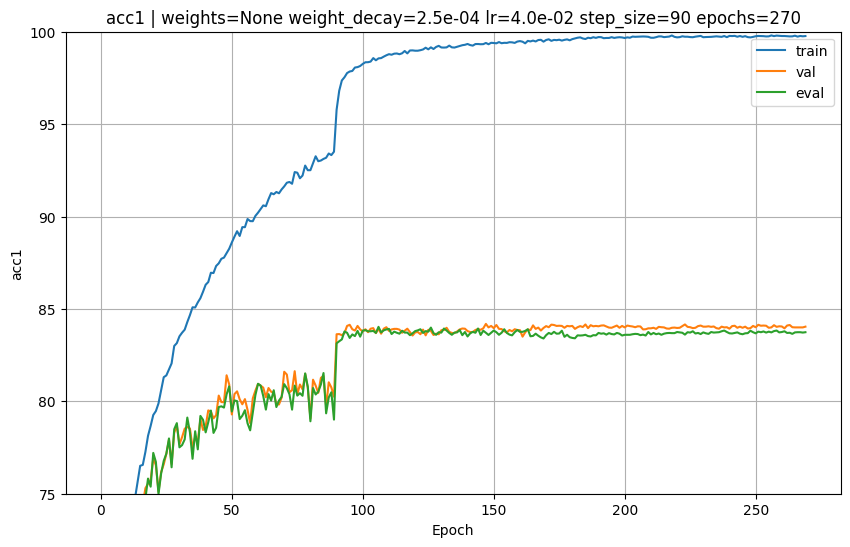

In [263]:
rplt.plot_run_splits(
    good_runs,
    all_runs_metrics,
    sweep_info,
    run_ind=0,
    ylim=(75, 100),
)

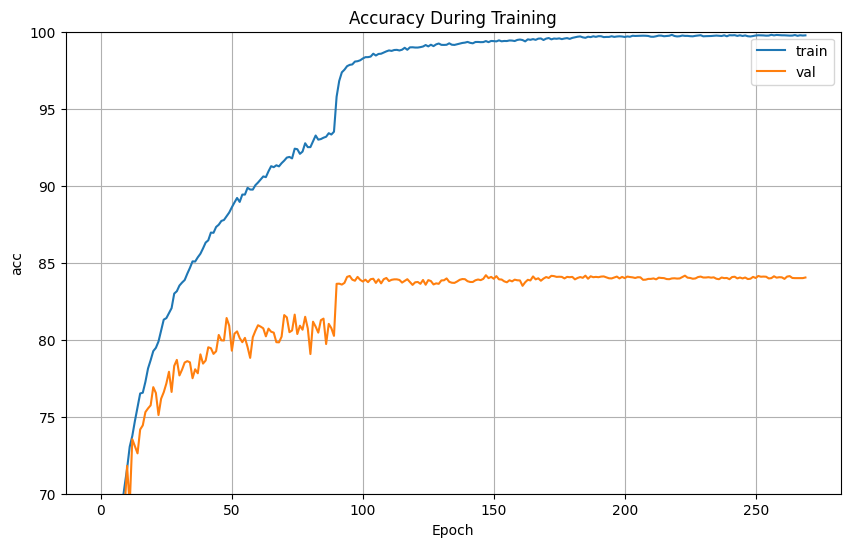

In [204]:
# Example: Plot multiple splits for same run
pu.plot_lines(
    pu.get_plt_cfg(
        ylabel="acc", title="Accuracy During Training",
        ylim=(70, 100), labels=['train', 'val']
    ),
    [
        rp.get_run_metrics(all_runs_metrics, "train", "acc1", 0),
        rp.get_run_metrics(all_runs_metrics, "val", "acc1", 0),
    ],
)

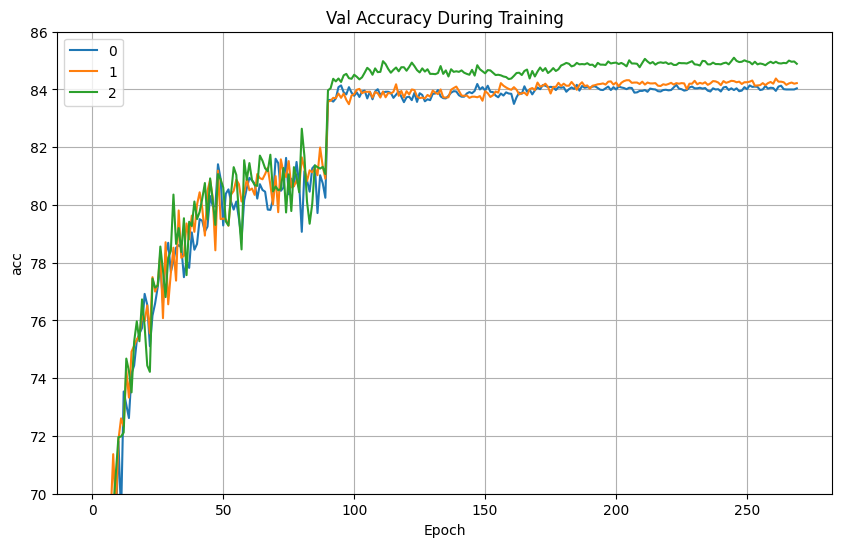

In [208]:
# Example: Plot one split for multiple inds (manually selected)
pu.plot_lines(
    pu.get_plt_cfg(
        ylabel="acc", title="Val Accuracy During Training",
        ylim=(70, 86), labels=[0,1,2],
    ),
    rp.get_runs_metrics(all_runs_metrics, "val", "acc1", [0,1,2]),
)

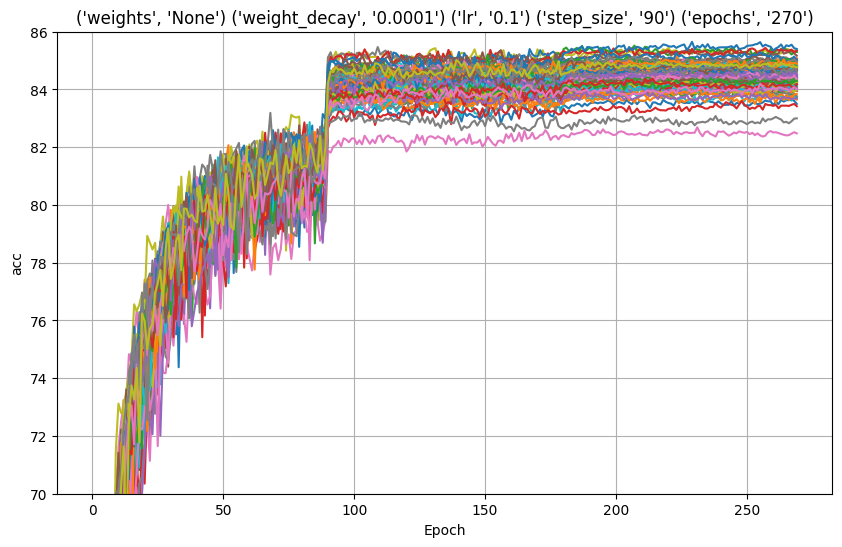

In [232]:
# Example: Plot one split for multiple inds (selected via combo)
selected_inds = rp.get_inds_by_kvs(
    sweep_info['combo_key_order'], sweep_info['combo_inds'],
    {
        'epochs': '270',
        'model.weights': 'None',
        'optim.lr': '0.1',
        'optim.weight_decay': '0.0001',
    },
)
selected_metrics = list(rp.get_selected_run_metrics(
    all_runs_metrics,
    "val",
    "acc1",
    selected_inds,
).items())
met_keys = [sm[0] for sm in selected_metrics]
met_values = [sm[1] for sm in selected_metrics]
pu.plot_lines(
    pu.get_plt_cfg(
        ylabel="acc",
        title=" ".join(
            [
                str((a.split(".")[-1], b)) for a, b in zip(
                    sweep_info['combo_key_order'], met_keys[0]
                )
            ]),
        ylim=(70, 86),
        legend=False,
        #labels=[str(k) for k in selected_metrics],
    ),
    met_values[0],
)

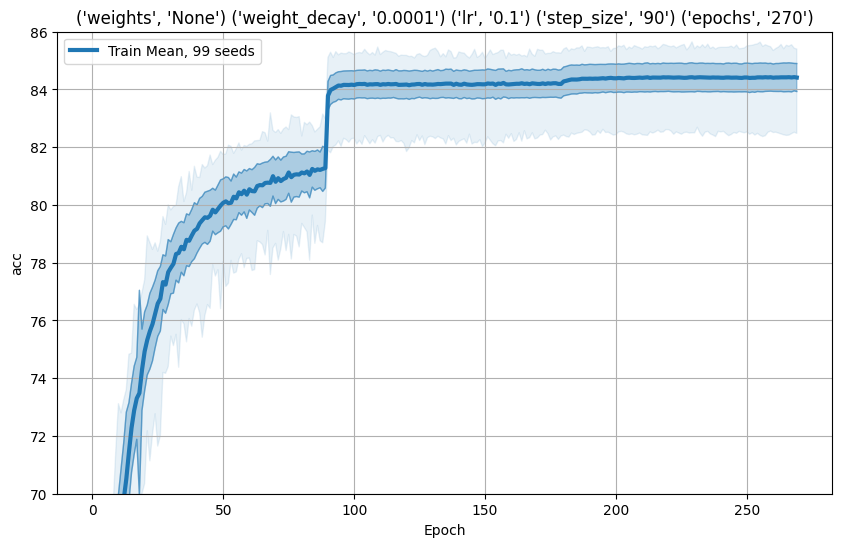

In [241]:
# Example: Plot one split for multiple inds (selected via combo)
selected_inds = rp.get_inds_by_kvs(
    sweep_info['combo_key_order'], sweep_info['combo_inds'],
    {
        'epochs': '270',
        'model.weights': 'None',
        'optim.lr': '0.1',
        'optim.weight_decay': '0.0001',
    },
)
selected_metrics = list(rp.get_selected_run_metrics(
    all_runs_metrics,
    "val",
    "acc1",
    selected_inds,
).items())
met_keys = [sm[0] for sm in selected_metrics]
met_values = [sm[1] for sm in selected_metrics]
pu.plot_summary_lines(
    pu.get_plt_cfg(
        ylabel="acc",
        title=" ".join(
            [
                str((a.split(".")[-1], b)) for a, b in zip(
                    sweep_info['combo_key_order'], met_keys[0]
                )
            ]),
        ylim=(70, 86),
        legend=True,
        labels=[f"Train Mean, {len(met_values[0])} seeds"],
        #labels=[str(k) for k in selected_metrics],
    ),
    met_values[0],
)

### Utils

#### Basic Plotting

In [222]:
def plot_histogram(plc, group_metrics, epoch, split, metric_name="acc1"):
    # [metric_by_epoch for run in run_group]
    all_runs_all_epochs_metrics = group_metrics[split][metric_name]
    # Get metrics for epoch
    metric_for_target_epoch_all_runs = [
        l[epoch] for l in all_runs_all_epochs_metrics if epoch < len(l)
    ]
        
    # Helper for plotting config
    def plcv(key, default):
        if key in plc and plc[key] is not None:
            return plc[key]
        return default

    # Plot the histogram using matplotlib
    plt.figure(figsize=plc.figsize)
    plt.hist(
        metric_for_target_epoch_all_runs,
        bins=plc.nbins, edgecolor='black', range=plc.hist_range,
    )
    plt.xlabel(plcv("xlabel", "acc1"))
    plt.ylabel(plcv("ylabel", "Frequency"))
    plt.title(plcv(
        "title",
        f"Histogram of {metric_name} values (split='{split}', epoch={epoch})"
    ))
    plt.grid(plc.grid)
    plt.show()

In [225]:
def plot_histograms(plc, group_metrics, epoch, metric_name="acc1", splits=["train", "val", "eval"]):
    # Set up a color map for splits.
    default_colors = {"train": "blue", "val": "green", "eval": "red"}
    colors = {split: default_colors.get(split, None) for split in splits}
    plt.figure(figsize=plc.figsize)

    # Helper for plotting config
    def plcv(key, default):
        if key in plc and plc[key] is not None:
            return plc[key]
        return default
    
    # Plot histogram for each split using histtype 'step' for overlay.
    for split in splits:
        # [metric_by_epoch for run in run_group]
        all_runs_all_epochs_metrics = group_metrics[split][metric_name]
        # Get metrics for epoch
        metric_for_target_epoch_all_runs = [
            l[epoch] for l in all_runs_all_epochs_metrics if epoch < len(l)
        ]
        plt.hist(
            metric_for_target_epoch_all_runs,
            bins=plc.nbins,
            edgecolor=colors[split],
            range=plc.hist_range,
            histtype='step',
            label=split,
        )
    
    plt.xlabel(plcv("xlabel", "acc1"))
    plt.ylabel(plcv("ylabel", "Frequency"))
    plt.title(plcv("title", f"Histogram of acc1 values at index {epoch} for splits {', '.join(splits)}"))
    if plc.legend:
        plt.legend()
    plt.grid(plc.grid)
    plt.show()

#### Stat Calculation

In [355]:
def extract_epoch_metric_vals(
    group_1_metrics, group_2_metrics,
    epoch, split, metric_name="acc1",
):
    vals_group_1 = [
        run_mets[epoch] for run_mets in
        group_1_metrics[split][metric_name]
        if len(run_mets) > epoch
    ]
    vals_group_2 = [
        run_mets[epoch] for run_mets in
        group_2_metrics[split][metric_name]
        if len(run_mets) > epoch
    ]
    return vals_group_1, vals_group_2

In [343]:
def find_max_diff_point(values1, values2):
    v1 = np.sort(np.array(values1))
    v2 = np.sort(np.array(values2))
    
    # Combine both arrays and get unique sorted values.
    all_vals = np.sort(np.unique(np.concatenate([v1, v2])))

    results = {}
    # For each unique value, compute the proportion of values in each sample that are <= that value.
    results['cdf1'] = np.searchsorted(v1, all_vals, side='right') / len(v1)
    results['cdf2'] = np.searchsorted(v2, all_vals, side='right') / len(v2)
    
    # Compute absolute differences between the two CDFs.
    differences = np.abs(results['cdf1'] - results['cdf2'])
    results['max_idx'] = np.argmax(differences)
    results['max_diff_value'] = all_vals[results['max_idx']]
    results['ks_stat'] = differences[results['max_idx']]
    return results

In [373]:
def calculate_ks_for_run_sets(
    group_1_metrics, group_2_metrics,
    epoch, split, metric_name="acc1",
):
    vals_1, vals_2 = extract_epoch_metric_vals(
        group_1_metrics, group_2_metrics,
        epoch, split, metric_name,
    )
    
    # Compute the KS statistic and p-value.
    ks_stat, p_value = stats.ks_2samp(vals_1, vals_2)

    # Identify contributing samples
    results = find_max_diff_point(vals_1, vals_2)
    results['p_value'] = p_value
    results['seeds_group_1'] = len(vals_1)
    results['seeds_group_2'] = len(vals_2)

    # Print Main Stats
    cdf1_val = results['cdf1'][results['max_idx']]
    cdf2_val = results['cdf2'][results['max_idx']]
    print(f"ks_stat: {ks_stat:0.4f}, p_value: {p_value:0.4e} | max_val: {results['max_diff_value']:0.2f}, cdf1_val: {cdf1_val:0.4f}, cdf2_val: {cdf2_val:0.4f}")
    return results
    

#### Advanced Plotting

In [367]:
def plot_histogram_compare(
    plc,
    group_1_metrics, group_2_metrics,
    epoch,
    split,
    metric_name="acc1",
):
    vals_1, vals_2 = extract_epoch_metric_vals(
        group_1_metrics, group_2_metrics,
        epoch, split, metric_name,
    )

    # Helper for plotting config
    def plcv(key, default):
        if key in plc and plc[key] is not None:
            return plc[key]
        return default
    
    plt.figure(figsize=plc.figsize)

    # Group 1
    plt.hist(
        vals_1, bins=plc.nbins, histtype='step', edgecolor='blue', 
        range=plc.hist_range, label=plc.labels[0] + f" n={len(vals_1)}",
        density=True,
    )
    mean1 = sum(vals_1) / len(vals_1)
    plt.axvline(mean1, color='blue', linestyle='dashed', linewidth=1.5, label=f'{plc.labels[0]} Mean: ({mean1:.2f})')

    # Group 2
    plt.hist(
        vals_2, bins=plc.nbins, histtype='step', edgecolor='red',
        range=plc.hist_range, label=plc.labels[1]  + f" n={len(vals_2)}",
        density=True,
    )
    mean2 = sum(vals_2) / len(vals_2)
    plt.axvline(mean2, color='red', linestyle='dashed', linewidth=1.5, label=f'{plc.labels[1]} Mean: ({mean2:.2f})')
        
    plt.xlabel(plcv("xlabel", "acc1"))
    plt.ylabel(plcv("ylabel", "Frequency"))
    plt.title(plcv("title", f"Histogram of acc1 values for split '{split}' at epoch {epoch}"))
    if plc.legend:
        plt.legend()
    plt.grid(plc.grid)
    plt.show()

In [371]:
def present_stats(metrics_groups, g1_name, g2_name, epoch, split):
    plot_histogram_compare(
        get_plt_cfg(
            legend=True, labels=[g1_name, g2_name],
            hist_range=(50, 100),
        ),
        metrics_groups[g1_name],
        metrics_groups[g2_name],
        epoch=epoch,
        split=split
    )
    ex_results = calculate_ks_for_run_sets(
        metrics_groups[g1_name],
        metrics_groups[g2_name],
        epoch=epoch,
        split=split,
    )
    print(ex_results['seeds_group_1'], ex_results['seeds_group_2'])

In [59]:
def present_stats(rs1, rs2, lb1, lb2, title, index, split, hist_range, nbins):
    plot_split_histogram_two_run_sets(
        rs1, rs2,
        index=index,
        split_name=split,
        hist_range=hist_range,
        nbins=nbins,
        names=[lb1, lb2],
        title=title,
    )
    ks_stat, p_value = calculate_ks_for_run_sets(
        rs1, rs2,
        index=index,
        split_name=split,
    )

### Find Relevant Logs & Basic Plotting

In [14]:
run_logs = get_all_logs("/scratch/ddr8143/logs")

>> Getting logs from all runs in: /scratch/ddr8143/logs
>>    found files: 974


In [15]:
parsed_cfg_metrics_meta = parse_run_logs(run_logs)
# excfg, exmets, exmeta = parsed_cfg_metrics_meta[0]

In [62]:
good_runs, error_runs = filter_parsed_runs(
    parsed_cfg_metrics_meta, lr=None, wd=None, init=None, # None == any
)

In [74]:
kv2ind, vkeys = extract_sweeps(good_runs)

UnboundLocalError: cannot access local variable 'v' where it is not associated with a value

In [64]:
for k, v in kv2ind.items():
    print(k)
    print(v)
    break

paths.root
defaultdict(<class 'list'>, {'/scratch/ddr8143': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209,

In [170]:
run_groups, error_runs = get_run_groups(parsed_cfg_metrics_meta)

 - random_lr0.01_wd0.0001         | found 20
 - random_lr0.01_wd1e-05          | found 20
 - random_lr0.1_wd0.0001          | found 100
 - random_lr0.1_wd1e-05           | found 20
 - random_lr0.2_wd0.0001          | found 20
 - random_lr0.2_wd1e-05           | found 20
 - pretrained_lr0.01_wd0.0001     | found 20
 - pretrained_lr0.01_wd1e-05      | found 5
 - pretrained_lr0.1_wd0.0001      | found 91
 - pretrained_lr0.1_wd1e-05       | No runs
 - pretrained_lr0.2_wd0.0001      | No runs
 - pretrained_lr0.2_wd1e-05       | No runs
>> Total error or unfinished runs: 17


In [325]:
run_group_metrics = get_run_groups_metrics(run_groups)
# print(run_group_metrics['random_lr0.1_wd0.0001']['train']['loss'][0][:4])

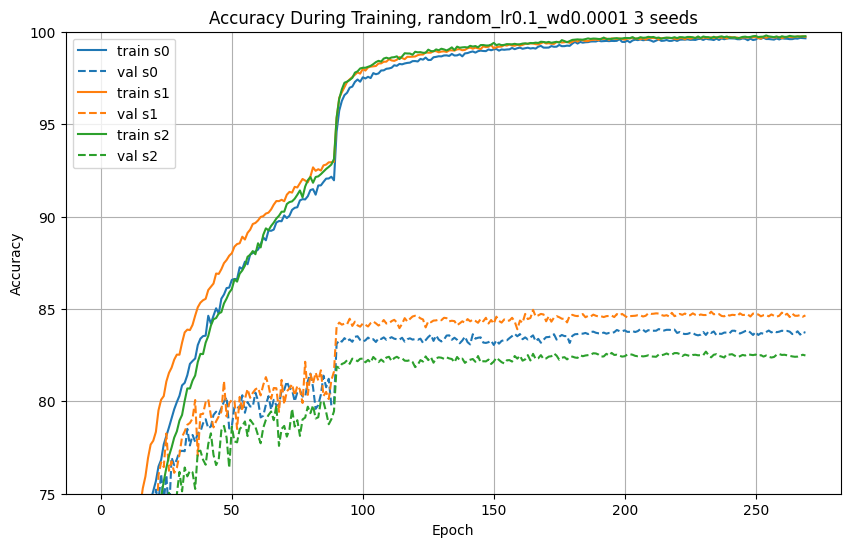

In [326]:
# Ungrouped: Selected Seeds
plot_parsed_metrics(
    get_plt_cfg(ylim=(75,100)),
    run_group_metrics,
    lr=0.1,
    wd=1e-4,
    init="random",
    seeds=[0,1,2],
    splits=['train', 'val'],
    group_seeds=False,
)

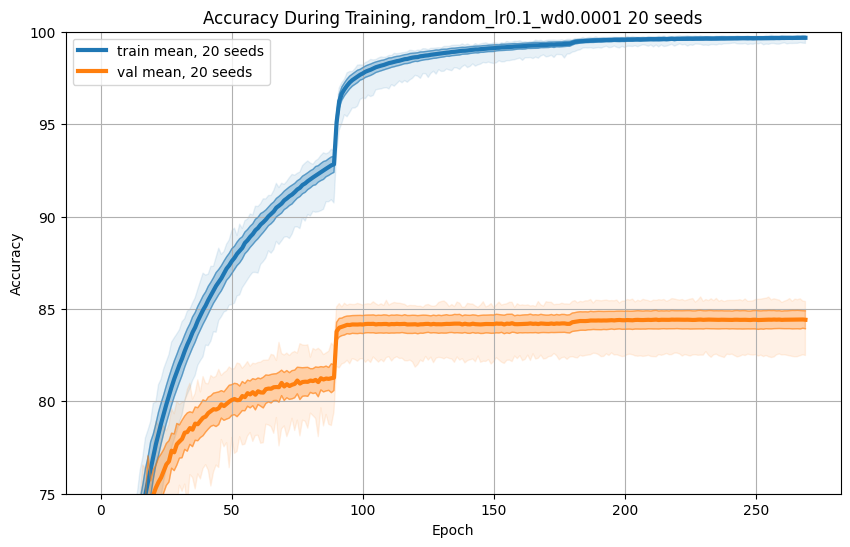

In [327]:
# Grouped: Some Seeds
plot_parsed_metrics(
    get_plt_cfg(ylim=(75,100)),
    run_group_metrics,
    lr=0.1,
    wd=1e-4,
    init="random",
    seeds=range(20),
    splits=['train', 'val'],
    group_seeds=True,
)

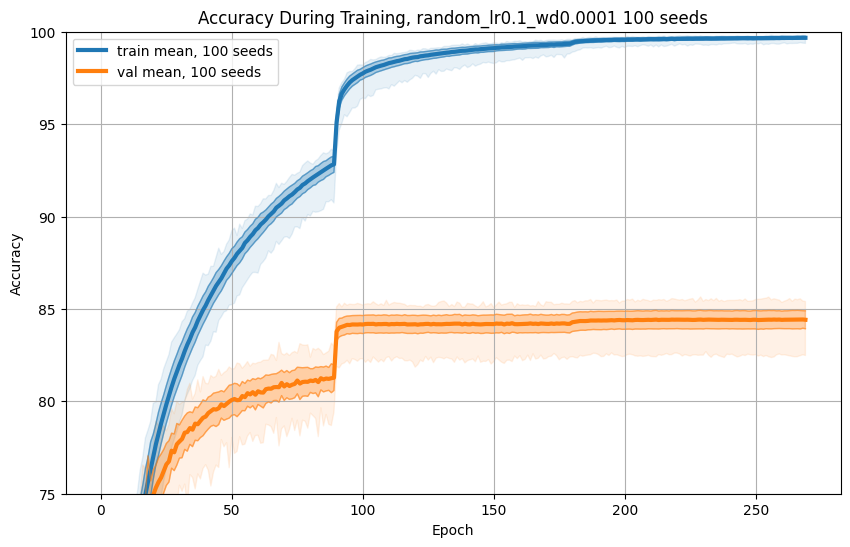

In [328]:
# Grouped, All Seeds
plot_parsed_metrics(
    get_plt_cfg(ylim=(75,100)),
    run_group_metrics,
    lr=0.1,
    wd=1e-4,
    init="random",
    seeds=None,
    splits=['train', 'val'],
    group_seeds=True,
)

### Histogram Plots

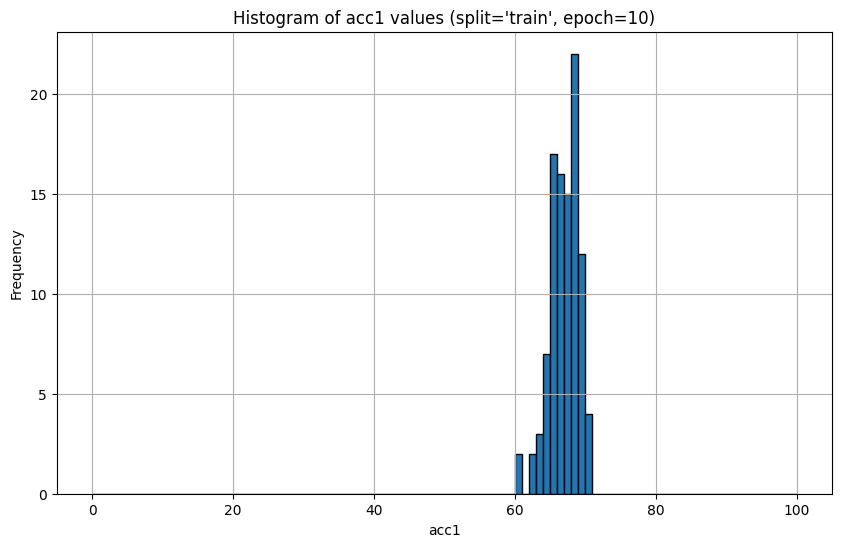

In [223]:
plot_histogram(
    get_plt_cfg(
        legend=True, labels=["random_lr0.1_wd0.0001"], hist_range=(0, 100),
    ),
    run_group_metrics['random_lr0.1_wd0.0001'],
    epoch=10,
    split="train",
)

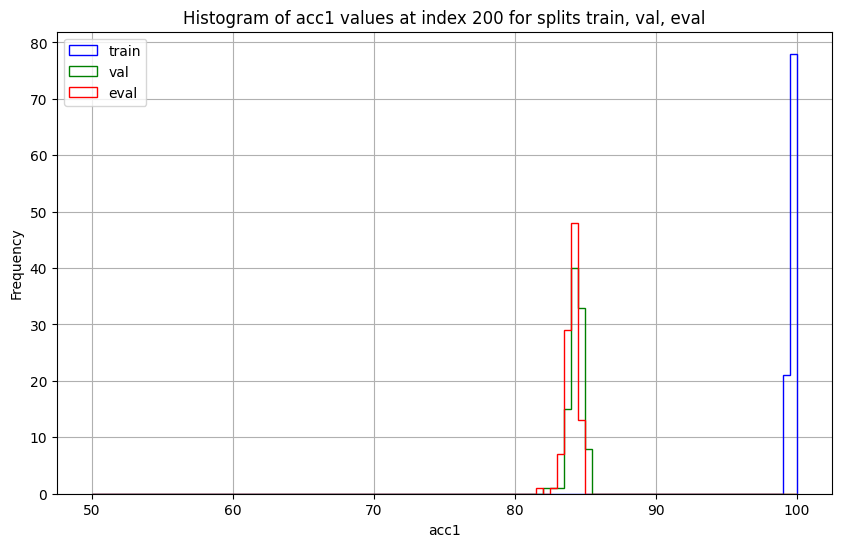

In [229]:
plot_histograms(
    get_plt_cfg(
        legend=True, labels=["train", "val", "eval"], hist_range=(50, 100),
    ),
    run_group_metrics['random_lr0.1_wd0.0001'],
    epoch=200,
    splits=["train", "val", "eval"],
)

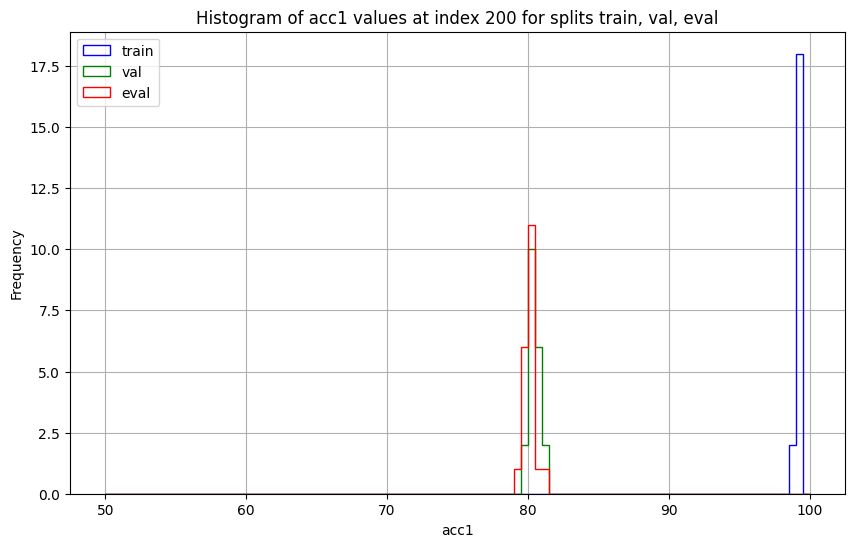

In [228]:
plot_histograms(
    get_plt_cfg(
        legend=True, labels=["train", "val", "eval"], hist_range=(50, 100),
    ),
    run_group_metrics['random_lr0.01_wd0.0001'],
    epoch=200,
    splits=["train", "val", "eval"],
)

### KS Stats Calculations

In [352]:
ex_results = calculate_ks_for_run_sets(
    run_group_metrics['random_lr0.1_wd0.0001'],
    run_group_metrics['random_lr0.01_wd0.0001'],
    epoch=200,
    split="val",
)
print(ex_results['seeds_group_1'], ex_results['seeds_group_2'])

ks_stat: 1.0000, p_value: 8.1460e-23 | max_val: 81.10, cdf1_val: 0.0000, cdf2_val: 1.0000
99 20


In [353]:
ex_results = calculate_ks_for_run_sets(
    run_group_metrics['random_lr0.1_wd0.0001'],
    run_group_metrics['random_lr0.2_wd0.0001'],
    epoch=200,
    split="val",
)
print(ex_results['seeds_group_1'], ex_results['seeds_group_2'])

ks_stat: 0.2692, p_value: 1.4117e-01 | max_val: 84.96, cdf1_val: 0.9192, cdf2_val: 0.6500
99 20


### Comparative Plots

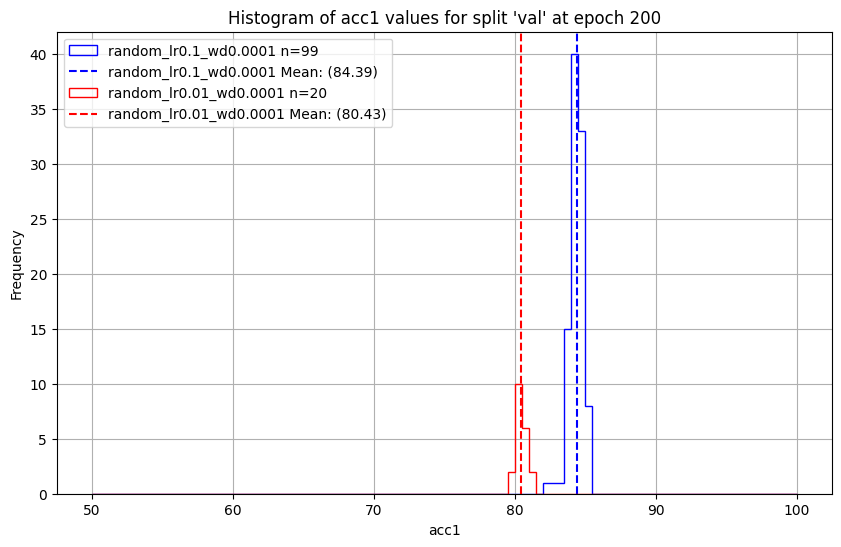

In [366]:
plot_histogram_compare(
    get_plt_cfg(
        legend=True, labels=["random_lr0.1_wd0.0001", "random_lr0.01_wd0.0001"],
        hist_range=(50, 100),
    ),
    run_group_metrics['random_lr0.1_wd0.0001'],
    run_group_metrics['random_lr0.01_wd0.0001'],
    epoch=200,
    split="val",
)

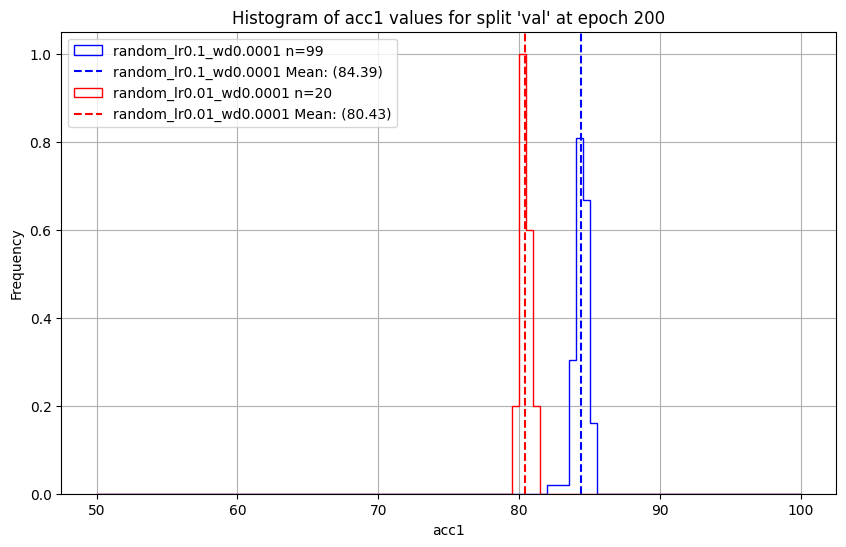

ks_stat: 1.0000, p_value: 8.1460e-23 | max_val: 81.10, cdf1_val: 0.0000, cdf2_val: 1.0000
99 20


In [374]:
present_stats(run_group_metrics, 'random_lr0.1_wd0.0001', 'random_lr0.01_wd0.0001', 200, "val")

### Old

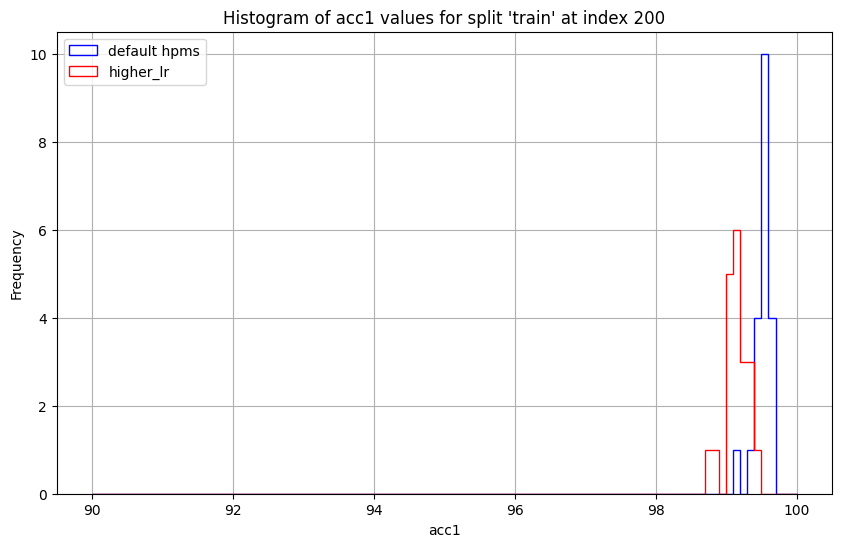

In [98]:
plot_split_histogram_two_run_sets(
    default_hpm_random_runs, higher_lr_random_runs, index=200, split_name="train", hist_range=(90,100), nbins=100, names=['default hpms', 'higher_lr']
)

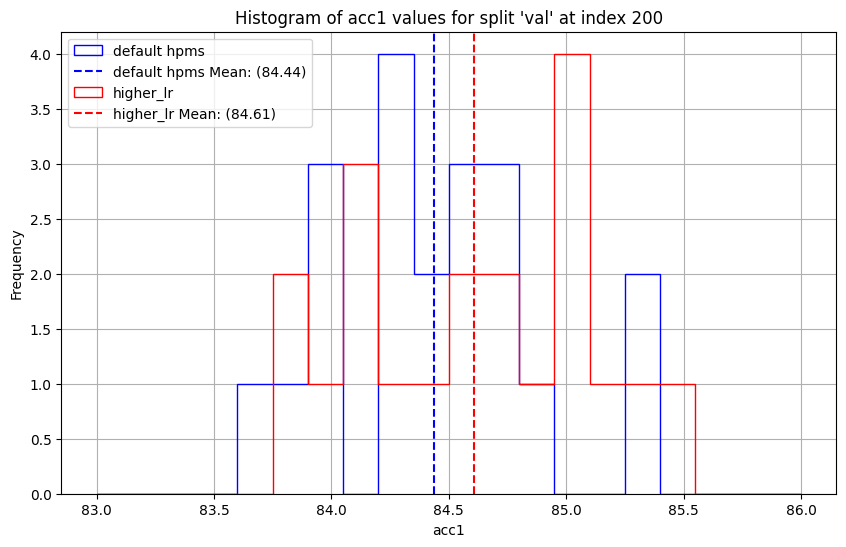

In [104]:
plot_split_histogram_two_run_sets(default_hpm_random_runs, higher_lr_random_runs, index=200, split_name="val", hist_range=(83,86), nbins=20, names=['default hpms', 'higher_lr'])

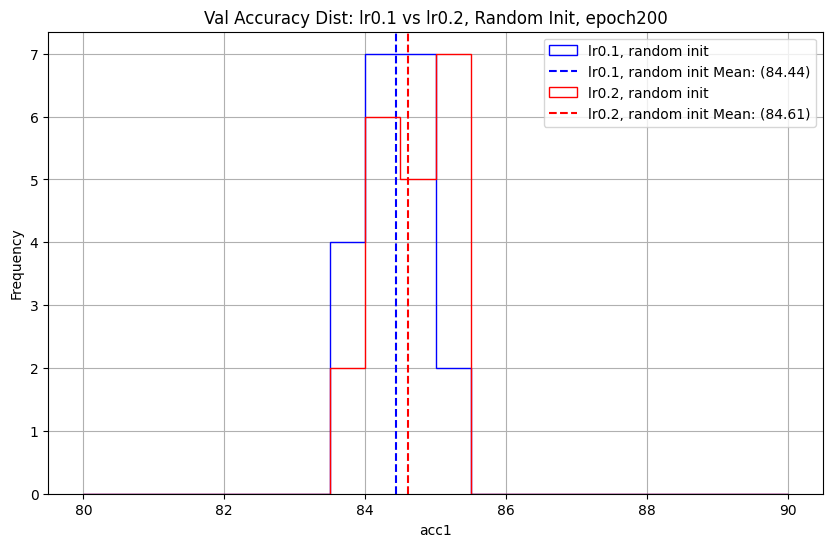

ks_stat: 0.3000, p_value: 3.3559e-01 | max_val: 84.81, cdf1_val: 0.9000, cdf2_val: 0.6000


In [65]:
present_stats(
    default_hpm_random_runs, higher_lr_random_runs,
    "lr0.1, random init", "lr0.2, random init",
    "Val Accuracy Dist: lr0.1 vs lr0.2, Random Init, epoch200",
    index=200, split="val", hist_range=(80,90), nbins=20,
)

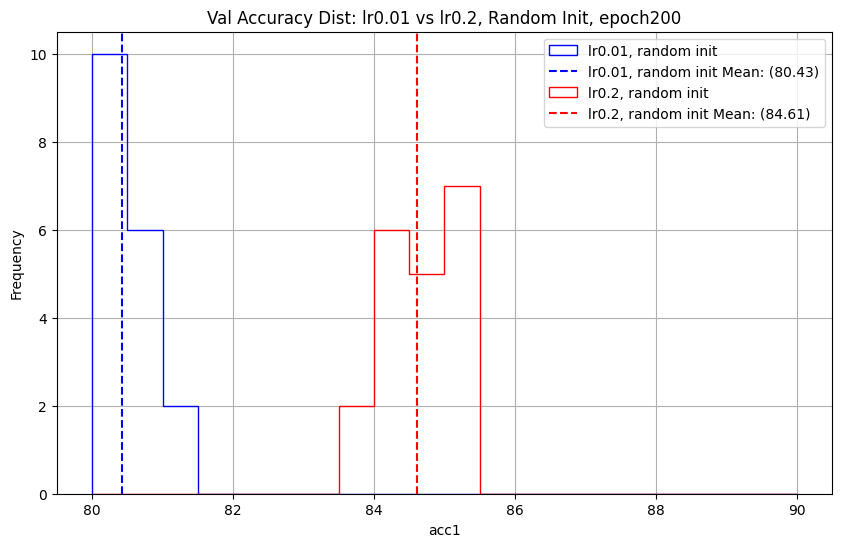

ks_stat: 1.0000, p_value: 1.4509e-11 | max_val: 81.10, cdf1_val: 1.0000, cdf2_val: 0.0000


In [66]:
present_stats(
    lower_lr_random_runs, higher_lr_random_runs,
    "lr0.01, random init", "lr0.2, random init",
    "Val Accuracy Dist: lr0.01 vs lr0.2, Random Init, epoch200",
    index=200, split="val", hist_range=(80,90), nbins=20,
)

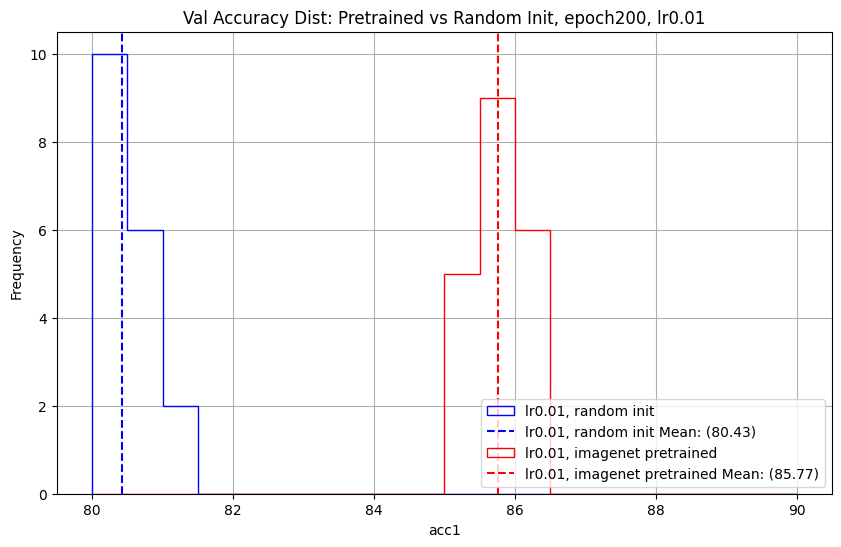

ks_stat: 1.0000, p_value: 1.4509e-11 | max_val: 81.10, cdf1_val: 1.0000, cdf2_val: 0.0000


In [63]:
present_stats(
    lower_lr_random_runs, lower_lr_pretrained_runs,
    "lr0.01, random init", "lr0.01, imagenet pretrained",
    "Val Accuracy Dist: Pretrained vs Random Init, epoch200, lr0.01",
    index=200, split="val", hist_range=(80,90), nbins=20,
)